In [70]:
import pandas as pd
import sklearn as sk
import sklearn.linear_model
import sklearn.preprocessing 
import sklearn.metrics
import sklearn.model_selection
import sklearn.cluster
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')

In [71]:
data = pd.read_csv('../data/processed_data.csv')
data.drop(['Weekend=False', 'Revenue=False'], axis=1, inplace=True)

In [72]:
page_count_duration_pairs = [
    ('Administrative', 'Administrative_Duration'),      
    ('Informational', 'Informational_Duration'),           
    ('ProductRelated', 'ProductRelated_Duration')
]
data['PageTypeVisited_Sum'] = pd.Series(0, index=data.index)
data['PageTypeDuration_Sum'] = pd.Series(0, index=data.index)
for c, d in page_count_duration_pairs:
    data[f'AvgDurationPer{c}PageType'] = data[d] / data[c]
    data[f'AvgDurationPer{c}PageType'].fillna(0, inplace=True)
    data['PageTypeVisited_Sum'] += data[c]
    data['PageTypeDuration_Sum'] += data[d]

In [73]:
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,VisitorType=New_Visitor,VisitorType=Other,VisitorType=Returning_Visitor,Weekend=True,Revenue=True,PageTypeVisited_Sum,PageTypeDuration_Sum,AvgDurationPerAdministrativePageType,AvgDurationPerInformationalPageType,AvgDurationPerProductRelatedPageType
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,1,0,0,1,0.000000,0.000000,0.0,0.000000
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,...,0,0,1,0,0,2,64.000000,0.000000,0.0,32.000000
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,...,0,0,1,0,0,1,0.000000,0.000000,0.0,0.000000
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,...,0,0,1,0,0,2,2.666667,0.000000,0.0,1.333333
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,...,0,0,1,1,0,10,627.500000,0.000000,0.0,62.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,...,0,0,1,1,0,56,1928.791667,48.333333,0.0,33.656447
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,...,0,0,1,1,0,5,465.750000,0.000000,0.0,93.150000
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,...,0,0,1,1,0,6,184.250000,0.000000,0.0,30.708333
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,...,0,0,1,0,0,19,421.000000,18.750000,0.0,23.066667


In [74]:
scaled_data = data.copy()
vars_to_scale = {
    'Administrative',
    'Administrative_Duration',
    'Informational',
    'Informational_Duration',
    'ProductRelated',
    'ProductRelated_Duration',
    'BounceRates',
    'ExitRates',
    'PageValues',
    'SpecialDay',
    'Month',
    'PageTypeVisited_Sum',
    'PageTypeDuration_Sum',
    'AvgDurationPerAdministrativePageType',
    'AvgDurationPerInformationalPageType',
    'AvgDurationPerProductRelatedPageType'
}
scaler = sk.preprocessing.StandardScaler()
scaled_vars = scaler.fit_transform(X=data[vars_to_scale])
scaled_data[list(vars_to_scale)] = scaled_vars
scaled_data.head()

scaled_data.to_csv('../data/feature_engineered_data.csv', index=False)

In [75]:
X = scaled_data.drop('Revenue=True', axis=1)
y = scaled_data['Revenue=True']
X_train, X_test, y_train, y_test = \
    sk.model_selection.train_test_split(X, y, 
                                        train_size=0.75, 
                                        stratify=y,
                                        random_state=1)

fs_model = sk.linear_model.LogisticRegressionCV(cv=5, 
                                                n_jobs=-1, 
                                                scoring='accuracy', 
                                                random_state=1, 
                                                max_iter=1000, 
                                                verbose=1)
fs_model.fit(X=X_train, y=y_train)
y_pred = fs_model.predict(X_test)
print(sk.metrics.classification_report(y_test, y_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


              precision    recall  f1-score   support

           0       0.90      0.98      0.94      2606
           1       0.76      0.39      0.52       477

    accuracy                           0.89      3083
   macro avg       0.83      0.69      0.73      3083
weighted avg       0.88      0.89      0.87      3083



[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.4s finished


In [97]:
coeffs = fs_model.coef_.reshape((-1, 1))
coeff_threshold_kmeans = sk.cluster.KMeans(n_clusters=2)
coeff_threshold_kmeans.fit(coeffs)
thresholds = coeff_threshold_kmeans.cluster_centers_

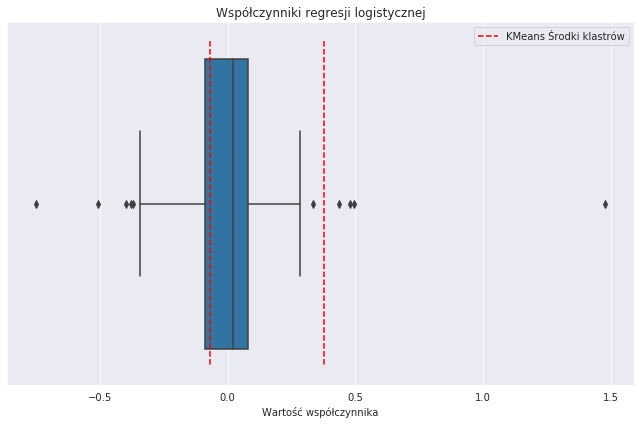

In [98]:
fig, ax = plt.subplots(figsize=(9,6))
sns.boxplot(coeffs)
ax.set_title('Współczynniki regresji logistycznej')
plt.vlines(thresholds, 
           ymin=-0.45, 
           ymax=0.45, 
           colors='r', 
           linestyles='dashed', 
           label='KMeans Środki klastrów')
plt.xlabel('Wartość współczynnika')
plt.legend()
plt.tight_layout()
plt.show()

In [110]:
column_names = list(scaled_data.columns)
upper_bound = thresholds.max()
lower_bound = thresholds.min()

variables = []
coeffs_series = pd.Series(coeffs.reshape(-1))
variables = variables + list(coeffs_series[coeffs_series <= lower_bound].index)
variables = variables + list(coeffs_series[coeffs_series >= upper_bound].index)

In [115]:
{i: (column_names[i], coeffs[i][0]) for i in variables}

{6: ('BounceRates', -0.09171759674284781),
 7: ('ExitRates', -0.7500322483643996),
 13: ('OperatingSystems=3', -0.09854284721232508),
 16: ('OperatingSystems=6', -0.15121977770984799),
 21: ('Browser=3', -0.370980686739226),
 22: ('Browser=4', -0.08182557336202409),
 24: ('Browser=6', -0.27011828237626034),
 31: ('Browser=13', -0.276047102943385),
 35: ('Region=4', -0.14549518237948153),
 36: ('Region=5', -0.16285263215475987),
 41: ('TrafficType=1', -0.13426696642014568),
 43: ('TrafficType=3', -0.27498916843443594),
 46: ('TrafficType=6', -0.10511979060877502),
 53: ('TrafficType=13', -0.37896004791910043),
 54: ('TrafficType=14', -0.19250218252812365),
 55: ('TrafficType=15', -0.3967630642299691),
 58: ('TrafficType=18', -0.15502951335198775),
 59: ('TrafficType=19', -0.3414908461533677),
 62: ('VisitorType=Other', -0.5080247131606732),
 8: ('PageValues', 1.4762816588350582),
 30: ('Browser=12', 0.43503951456449386),
 48: ('TrafficType=8', 0.48010437845861975),
 51: ('TrafficType=11